TO DO: 

- check that now supposed to be no overlap between fragment link and all structures - should i take out structures that are similar to fragments? 
- stil stuck on getting conformers - need coords?
- stuck on clustering
- try aligning one query mol to fragment cloud - then just need to expand for multiple mols and conformers
- brute force approach
- compare to RANSAC, ICP
- quantify
- substructure matching

FRAGMENTS: 

- get SD files
- convert to mol objects
- get pharmacophore points

QUERY MOLECULES:

- get SD files
- convert to mol objects
- get conformers
- get pharmacophore points

FUNCTION TO GET ALL SDF IN DIRECTORY

In [3]:
import os
from rdkit import Chem


def get_sdfs(dir_name):
    
    sdf_files = []
    filenames = []

    # collect sdf files from dirs
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith(".sdf"):
                # ignore combined sdf file
                if 'Mpro_combined' not in file:
                    sdf_files.append(os.path.join(root, file))
                    filenames.append(file)

    return sdf_files, filenames


CONVERT SDF TO MOL OBJECTS IN RDKIT

https://www.rdkit.org/docs/GettingStartedInPython.html

In [4]:
# get mol object for each sdf file

def sdf_to_mol(sdf_file_list):
   
   mols = []
   for sdf_file in sdf_file_list:
      with Chem.SDMolSupplier(sdf_file) as suppl:
         for mol in suppl:
            if mol is None: continue
            mols.append(mol)

   return mols


EXTRACT PHARMACOPHORES AND COORDINATES
http://rdkit.blogspot.com/2017/11/using-feature-maps.html 

In [5]:
# code to generate pharmacophores
import numpy as np
from rdkit import RDConfig, Chem
from rdkit.Chem import AllChem
from collections import defaultdict

# feature factory defines set of pharmacophore features being used 
_FEATURES_FACTORY, _FEATURES_NAMES = [], []

def get_features_factory(features_names, resetPharmacophoreFactory=False):

    global _FEATURES_FACTORY, _FEATURES_NAMES

    if resetPharmacophoreFactory or (len(_FEATURES_FACTORY) > 0 and _FEATURES_FACTORY[-1] != features_names):
        _FEATURES_FACTORY.pop()
       # _FEATURES_FACTORY.pop() # NOTE repeated line?
    if len(_FEATURES_FACTORY) == 0:
        feature_factory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
        _FEATURES_NAMES = features_names
        if features_names is None:
            features_names = list(feature_factory.GetFeatureFamilies())

        _FEATURES_FACTORY.extend([feature_factory, features_names])

    return _FEATURES_FACTORY

In [6]:
# NOTE ask re conformers here vs for query mols

def getPharmacophoreCoords(mol, features_names=["Acceptor", "Donor", "Aromatic"], confId=-1):

    # find features of a molecule
    feature_factory, keep_featnames = get_features_factory(features_names)
    rawFeats = feature_factory.GetFeaturesForMol(mol, confId=confId)
    featsDict = defaultdict(list)
    idxsDict = defaultdict(list)

    for f in rawFeats:
        if f.GetFamily() in keep_featnames:
            featsDict[f.GetFamily()].append(np.array(f.GetPos(confId=f.GetActiveConformer())))
            idxsDict[f.GetFamily()].append(np.array(f.GetAtomIds()))

    new_feats_dict = {}
    for key in featsDict:
        new_feats_dict[key] = np.concatenate(featsDict[key]).reshape((-1,3))
    
    return new_feats_dict, idxsDict


SEPARATE PHARMACOPHORE DICT INTO COORDS FOR DONOR, ACCEPTOR, AROMATIC

In [47]:
# compute pharmacophores coordinates

def get_coords(mols):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []

    for mol in mols:
        # .get() will just fill with None if key doesn't exist
        pharma_coords, __ = getPharmacophoreCoords(mol)
        donor_coord = pharma_coords.get('Donor')
        acceptor_coord = pharma_coords.get('Acceptor')
        aromatic_coord = pharma_coords.get('Aromatic')

        donor_coords.append(donor_coord)
        acceptor_coords.append(acceptor_coord)
        aromatic_coords.append(aromatic_coord)

    # remove None values
    donor_coords = [x for x in donor_coords if x is not None]
    acceptor_coords = [x for x in acceptor_coords if x is not None]
    aromatic_coords = [x for x in aromatic_coords if x is not None]

    if len(donor_coords) == 0:
        donor_coords = donor_coords
    else: 
        donor_coords = np.concatenate(donor_coords)
    
    if len(acceptor_coords) == 0:
        acceptor_coords = acceptor_coords
    else:
        acceptor_coords = np.concatenate(acceptor_coords)

    if len(aromatic_coords) == 0:
        aromatic_coords = aromatic_coords
    else:
        aromatic_coords = np.concatenate(aromatic_coords)

    return donor_coords, acceptor_coords, aromatic_coords


PLOT PHARMACOPHORE CLOUD

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_coords(donor_coords, acceptor_coords, aromatic_coords):
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    # visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
    labels = ['Donor', 'Acceptor', 'Aromatic']
    for coords, label in zip([donor_coords, acceptor_coords, aromatic_coords], labels):
        if len(coords) != 0:
            ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

    plt.legend()
    plt.show()

    return

SETTING UP FRAGMENT POINT CLOUD

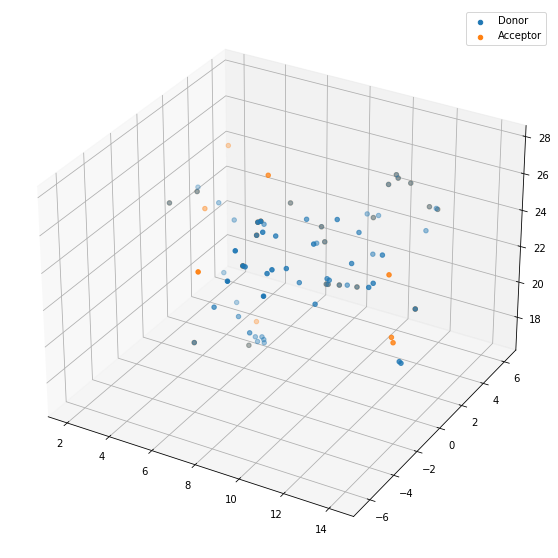

In [49]:
# run above functions
fragment_files, frag_filenames = get_sdfs('Mpro_fragments')
frag_mols = sdf_to_mol(fragment_files)
frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords = get_coords(frag_mols)
plot_coords(frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords)


clustering

hierarchical clustering (agglomerative sklearn)

we want to reduce the number of points? 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

donors = np.array([donor_coords[:,0], donor_coords[:,1], donor_coords[:,2]])
acceptors = np.array([acceptor_coords[:,0], acceptor_coords[:,1], acceptor_coords[:,2]])

def cluster(data):

    model = AgglomerativeClustering(linkage='average', n_clusters=None, distance_threshold=1.5)
    model.fit_predict(data)
    pred = model.fit_predict(data)
    print("number of cluster found: {}".format(len(set(model.labels_))))
    print('cluster for each point: ', model.labels_)

    return pred


# plot before clustering
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(donors[0], donors[1], donors[2])
ax.scatter3D(acceptors[0], acceptors[1], acceptors[2])
plt.show()


NameError: name 'donor_coords' is not defined

QUERY MOLECULES

In [55]:
# run same functions for query mols
query_sdfs, query_filenames = get_sdfs('Mpro_all') 
query_mols = sdf_to_mol(query_sdfs)

for mol in query_mols:
    molH = Chem.AddHs(mol) 
    #query_pharma_dict, __ = getPharmacophoreCoords(molH)
    conf = mol.GetConformers()

        # generate conformers
    #ids = AllChem.EmbedMultipleConfs(mol, numConfs=10, params=AllChem.ETKDG())
        
    # perform the alignment
    #for cid in ids:
    #    print(cid)
        #i += 1
        #query_pharma_dict, __ = getPharmacophoreCoords(cid)
        #print('MOL NUM', i, query_pharma_dict)

# TODO get conformers
'''
for mol in query_mols:
    # get 3D ph4 coords of each query molecule
    query_pharma_dict, __ = getPharmacophoreCoords(mol)
    # get conformers
    conf = mol.GetConformers()
    # plot molecules'''


'''
# get conformers for one molecule
def get_conformers(mol):
    # we will need to generate "ALL" possible conformers (3D) and check all
    #molH = Chem.AddHs(mol) # NOTE why add hydrogens, don't know this
    # generate conformers
    conf = mol.GetConformers()
    conf = conf.GetAtomPosition()
    for c in conf:
        query_donor_coords, query_acceptor_coords, query_aromatic_coords = get_coords(conf)
        # plot to visualise
        plot_coords(query_donor_coords, query_acceptor_coords, query_aromatic_coords)
    return 

for mol in frag_mols:
    get_conformers(mol)


# pseudocode for above fix ^^

for conf in mol.GetConformers():
    conf #object
    idx = conf.GetIdxs()
    ph4 
    or for idx in range(mol.getNumConformers())'''


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToMolBlock(_ROConformerSeq)
did not match C++ signature:
    MolToMolBlock(RDKit::ROMol mol, bool includeStereo=True, int confId=-1, bool kekulize=True, bool forceV3000=False)

TEST ONE QUERY MOL AGAINST FRAGMENT CLOUD (just one conformer)

In [73]:
query_pharma_dict, __ = getPharmacophoreCoords(query_mols[0])
query_donor_coords, query_acceptor_coords = query_pharma_dict['Donor'], query_pharma_dict['Acceptor']


trying to use my kabsch functions to align query to fragment cloud:

In [96]:
import sabs_kabsch.kabsch_functions as kabsch

query_points = np.concatenate([query_pharma_dict['Donor'], query_pharma_dict['Acceptor']])
pocket_points = np.concatenate([frag_donor_coords, frag_acceptor_coords])

query_points = np.array([query_points[0:,], query_points[1:,], query_points[2:,]], dtype='object')
pocket_points = np.array([pocket_points[0:,], pocket_points[1:,], pocket_points[2:,]], dtype='object')

qm_trans, qm_means = kabsch.translate_to_origin(query_points)
frm_trans, frm_means = kabsch.translate_to_origin(pocket_points)
h = kabsch.compute_covariance_matrix(qm_trans, frm_trans)
r = kabsch.compute_optimal_rotation_matrix(h)
qm_rotated = kabsch.apply_rotation(qm_trans, r)
qm_reverted, frm_reverted = kabsch.revert_translation(qm_rotated, frm_trans, qm_means, frm_means)


ax = plt.figure(figsize=(15,15)).add_subplot(projection='3d')

# plot matrices for comparison 
ax.plot(qm_reverted[0], qm_reverted[1], qm_reverted[2], label='Query', color='r')
ax.plot(frm_reverted[0], frm_reverted[1], frm_reverted[2], label='Fragments', color='b')

# set plot titles and labels
ax.legend(loc='upper left', fontsize=20)
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
plt.title('Test query mapped to fragments', fontsize=20)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/gemmagordon/opt/anaconda3/envs/my-rdkit-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/mz/rsbnnql93ndg_pc9ssszfpz40000gn/T/ipykernel_1178/998486576.py", line 9, in <cell line: 9>
    qm_trans, qm_means = kabsch.translate_to_origin(query_points)
  File "/Users/gemmagordon/opt/anaconda3/envs/my-rdkit-env/lib/python3.8/site-packages/sabs_kabsch/kabsch_functions.py", line 102, in translate_to_origin
    matrix_means = np.mean(matrix, axis=1)
  File "<__array_function__ internals>", line 5, in mean
  File "/Users/gemmagordon/opt/anaconda3/envs/my-rdkit-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3419, in mean
    by the number of elements.
  File "/Users/gemmagordon/opt/anaconda3/envs/my-rdkit-env/lib/python3.8/site-packages/numpy/core/_methods.py", line 166, in _mean
  File "/Users/gemmagordon/opt/anacon